# Deep Raw Image Denoising

<hr />

This is a demo to run the mdoel

# 1. Setup
- First, in the **Runtime** menu -> **Change runtime type**, make sure to have ```Hardware Accelerator = GPU```
- Clone repo and install dependencies.
- Maybe you can run this with CPU

In [ ]:
# If cuda is not available, use the following line to run the script
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    device = '/GPU:0'
else:
    device = '/CPU:0'

print(f'Using device: {device}')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_logical_devices('GPU'))

In [ ]:
import os
!pip install einops

if os.path.isDir('Practical-Deep-Raw-Image-Denoising-on-Mobile-Devices'):
  !rm -r Practical-Deep-Raw-Image-Denoising-on-Mobile-Devices

# Clone the repository
!git clone https://github.com/danielliu-meridian/Practical-Deep-Raw-Image-Denoising-on-Mobile-Devices.git
%cd Practical-Deep-Raw-Image-Denoising-on-Mobile-Devices

# 2. Define Task and Download Pre-processed data

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Num GPUs Available:  1
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


Create and Buil Model

In [5]:
model = DenoiseNetwork()
model.build((None,512,512,3))
len(model.weights)

138

# Loss Function and Train_step

In [8]:
import sys

def progress(epoch, trained_sample ,total_sample, bar_length=25, loss=0, message=""):
  percent = float(trained_sample) / float(total_sample)
  hashes = '#' * int(tf.round(percent * bar_length))
  spaces = ' ' * (bar_length - len(hashes))
  sys.stdout.write("\rEpoch {0}: [{1}] {2}%  ----- Loss: {3}".format(epoch, hashes + spaces, int(round(percent * 100)), float(loss)) + message)
  sys.stdout.flush()

In [9]:
def fit(model, lr, clean_imgs, noisy_imgs, epochs):
  history = []
  optimizer = tf.keras.optimizers.Adam(lr)
  for e in range(epochs):
    total_loss = [1]
    for ite, (clean_img, noisy_img) in tf.data.Dataset.zip((clean_imgs, noisy_imgs)).enumerate():

      loss = train_step(model, optimizer, clean_img, noisy_img)
      progress(e+1, (ite+1), len(clean_imgs), loss=loss)
      total_loss.append(loss)
    history.append(sum(total_loss) / len(total_loss))
    print("\n Epoch {0}: --- Avg Loss: {1}".format(e+1, sum(total_loss) / len(total_loss)))
  return history

# Load Data

In [17]:
def load_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_png(img, 3)
  img = tf.cast(img, tf.float32)
  # img = tf.image.resize(img, [512, 512])
  return img / 255.0

BATCH_SIZE = 16

data_path1 = "/content/drive/My Drive/Data/sidd_rgb1/"
data_path2 = "/content/drive/My Drive/Data/sidd_rgb2/"

BATCH_SIZE = 8

clean_path1 = tf.data.Dataset.list_files(data_path1 + '/clean/*.png', shuffle=False)
noisy_path1 = tf.data.Dataset.list_files(data_path1 + '/noisy/*.png', shuffle=False)

clean_path2 = tf.data.Dataset.list_files(data_path2 + '/clean/*.png', shuffle=False)
noisy_path2 = tf.data.Dataset.list_files(data_path2 + '/noisy/*.png', shuffle=False)

clean_path = clean_path1.concatenate(clean_path2)
noisy_path = noisy_path1.concatenate(noisy_path2)

clean_imgs = clean_path.map(lambda x: load_image(x)).batch(BATCH_SIZE)
noisy_imgs = noisy_path.map(lambda x: load_image(x)).batch(BATCH_SIZE)

Train with first 20 epochs

In [ ]:
history = fit(model, 1e-3, clean_imgs, noisy_imgs, 20)

Epoch 1: [#########################] 100%  ----- Loss: 6180.927734375
 Epoch 1: --- Avg Loss: 6680.73388671875
Epoch 2: [#########################] 100%  ----- Loss: 6098.9521484375
 Epoch 2: --- Avg Loss: 4344.837890625
Epoch 3: [#########################] 100%  ----- Loss: 6162.5419921875
 Epoch 3: --- Avg Loss: 4040.492919921875
Epoch 4: [#########################] 100%  ----- Loss: 6165.201171875
 Epoch 4: --- Avg Loss: 3856.072509765625
Epoch 5: [#########################] 100%  ----- Loss: 6453.93896484375
 Epoch 5: --- Avg Loss: 3674.99267578125
Epoch 6: [#########################] 100%  ----- Loss: 6257.0380859375
 Epoch 6: --- Avg Loss: 3601.1455078125
Epoch 7: [#########################] 100%  ----- Loss: 5604.1357421875
 Epoch 7: --- Avg Loss: 3342.703857421875
Epoch 8: [#########################] 100%  ----- Loss: 5400.5791015625
 Epoch 8: --- Avg Loss: 3162.960693359375
Epoch 9: [#########################] 100%  ----- Loss: 5147.63134765625
 Epoch 9: --- Avg Loss: 3018.811

In [11]:
# Save weight
model.load_weights("/content/drive/My Drive/Raw Image Denoising/Weights/ckpt")

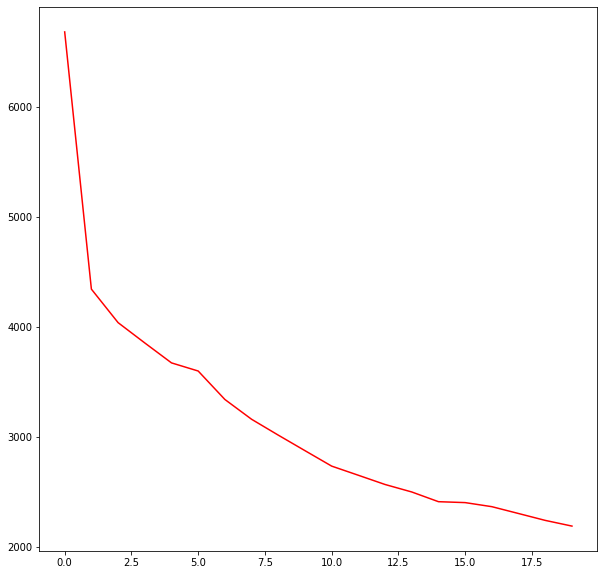

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.plot(range(len(history)), history, 'r-')

In [12]:
source = iter(noisy_imgs).next()
target = iter(clean_imgs).next()

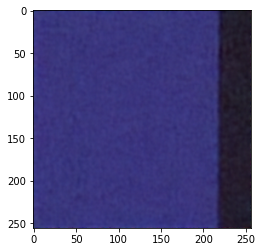

In [16]:
import matplotlib.pyplot as plt

pred = model(source)
img = pred[0]
plt.imshow(img)